In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a1e916bae74c0725f0cd28078e6e23029d42afabeab43092fab066454918c208
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


In [3]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
!pip install accelerate -U

In [5]:
import os
import numpy as np
import datasets
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
os.environ["WANDB_DISABLED"] = "true"
class config :
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [7]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [8]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


<ipython-input-8-15d4c46f5e43>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import zipfile

# Specify the path to the uploaded zip file
zip_file_path = 'drive/MyDrive/custom_captions_dataset.zip'

# Specify the directory where you want to extract the contents
extracti_dir = '/content/custom_captions_dataset'

# Create the extract directory if it doesn't exist
os.makedirs(extracti_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracti_dir)


In [13]:
import torchvision.transforms as transforms

transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        )
   ]
)
df1=  pd.read_csv("/content/custom_captions_dataset/custom_captions_dataset/train.csv")
train_df = df1.iloc[:, 1:3]

df2= pd.read_csv("/content/custom_captions_dataset/custom_captions_dataset/val.csv")
val_df = df2.iloc[:, 1:3]

In [14]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 300
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.filename.iloc[idx]
        img_path = os.path.join(self.root_dir,image)
        img = Image.open(img_path).convert("RGB")


        if self.transform is not None:
            img= self.transform(img)

        img = (img+1)/2
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding

In [15]:
train_dataset = ImgDataset(train_df, root_dir = "/content/custom_captions_dataset/custom_captions_dataset/train",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/content/custom_captions_dataset/custom_captions_dataset/val",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

In [16]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [17]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [18]:
from transformers import Seq2SeqTrainingArguments


training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
trainer=Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.494114,0.078300,0.144100,0.097700
2,2.677800,2.401710,0.068600,0.130100,0.086600
3,2.370400,2.373385,0.064400,0.128700,0.082700


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don

TrainOutput(global_step=2145, training_loss=2.514048052167559, metrics={'train_runtime': 5856.3062, 'train_samples_per_second': 2.928, 'train_steps_per_second': 0.366, 'total_flos': 3.0940534132545946e+18, 'train_loss': 2.514048052167559, 'epoch': 3.0})

In [20]:
trainer.save_model('VIT_large_gpt2')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


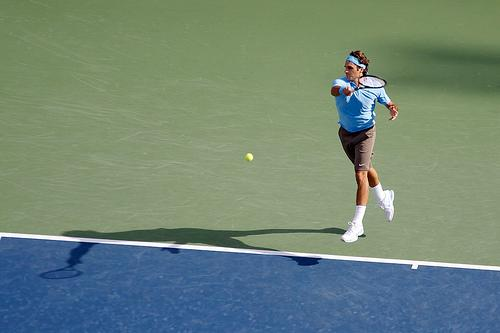

In [21]:
img_ =  Image.open("/content/custom_captions_dataset/custom_captions_dataset/test/test_25.jpg").convert("RGB")
img_

In [22]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img_, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:142]+ '\033[0m')

<|endoftext|>A man is standing on a tennis court. He is wearing a white shirt and blue shorts. The man is holding a racket in his right hand. 


In [23]:
df3 = pd.read_csv("/content/custom_captions_dataset/custom_captions_dataset/test.csv")
test_df=df3.iloc[:, 1:3]

# Define the dataset using ImgDataset class
test_dataset = ImgDataset(test_df, root_dir="/content/custom_captions_dataset/custom_captions_dataset/test", tokenizer=tokenizer, feature_extractor=feature_extractor, transform=transforms)

# Define a function to generate captions for test images
def generate_captions(dataset):
    captions = []
    for idx in range(len(dataset)):
        inputs = dataset[idx]
        img_tensor = inputs["pixel_values"].unsqueeze(0).to(device)
        generated_caption = tokenizer.decode(model.generate(img_tensor)[0])
        captions.append(generated_caption)
    return captions

# Generate captions for test dataset
generated_captions = generate_captions(test_dataset)

# Assuming you have ground truth captions for evaluation
ground_truth_captions = test_df["caption"].tolist()




In [43]:
!git clone https://github.com/vrama91/cider.git
%cd cider
!python setup.py install


Cloning into 'cider'...
remote: Enumerating objects: 218, done.
remote: Total 218 (delta 0), reused 0 (delta 0), pack-reused 218
Receiving objects: 100% (218/218), 31.08 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/cider
python3: can't open file '/content/cider/setup.py': [Errno 2] No such file or directory


In [3]:
from cider.pyciderevalcap.cider.cider import Cider

# Assuming df_mode represents the mode of your dataframe, such as 'train', 'val', or 'test'
df_mode = "test"

ground_truth_data = [{'image_id': i, 'caption': caption} for i, caption in enumerate(ground_truth_captions)]

# Format generated captions
generated_data = [{'image_id': i, 'caption': caption} for i, caption in enumerate(generated_captions_list)]

# Print the first few elements of ground_truth_data and generated_data
print("First few elements of ground_truth_data:", ground_truth_data[:5])
print("First few elements of generated_data:", generated_data[:5])

# Check the type of the first caption in ground_truth_data and generated_data
print("Type of the first caption in ground_truth_data:", type(ground_truth_data[0]['caption']))
print("Type of the first caption in generated_data:", type(generated_data[0]['caption']))

# Format ground truth captions as lists of strings
for item in ground_truth_data:
    item['caption'] = [item['caption']]

# Format generated captions as lists of strings
for item in generated_data:
    item['caption'] = [item['caption']]

# Initialize the Cider with the appropriate arguments
cider = Cider(df_mode)

# Now you can compute the CIDEr scores
cider_scores = cider.compute_score(ground_truth_data, generated_data)
cider_score = sum(cider_scores) / len(cider_scores)
print("CIDEr Score:", cider_score)


CIDEr Score: 0.24473210931828393


In [33]:
!pip install rouge

In [34]:
from rouge import Rouge

rouge = Rouge()
rouge_scores = rouge.get_scores(generated_captions,ground_truth_captions, avg=True)
rouge_l_score = rouge_scores["rouge-l"]["f"]
print("ROUGE-L Score:", rouge_l_score)


ROUGE-L Score: 0.2873843743802736


In [36]:
!pip install SpicePy

In [2]:
import spicepy
# Initialize the SPICE scorer

spice = spicepy.Spice()

# Compute SPICE scores
spice_scores = spice.compute_score(ground_truth_captions, generated_captions)

# Extract the overall SPICE score
spice_score = spice_scores[0]["All"]["f"]

print("SPICE Score:", spice_score)


SPICE Score: 0.2913853228547193
